## This notebook experiments with the python package "timeseries-generator"

In [1]:
#from timeseries_generator import LinearTrend, Generator, WhiteNoise, RandomFeatureFactor
#import pandas as pd
#%matplotlib inline


import pandas as pd
from pandas._libs.tslibs.timestamps import Timestamp
from timeseries_generator.external_factors import CountryGdpFactor, EUIndustryProductFactor
from timeseries_generator import Generator, HolidayFactor, LinearTrend, RandomFeatureFactor, SinusoidalFactor, WeekdayFactor, WhiteNoise


# Setting up parameters

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:xlabel='date'>)

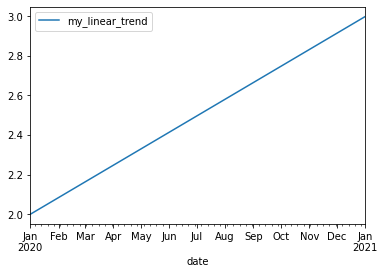

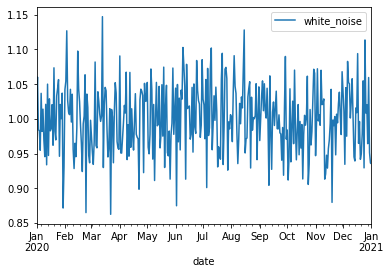

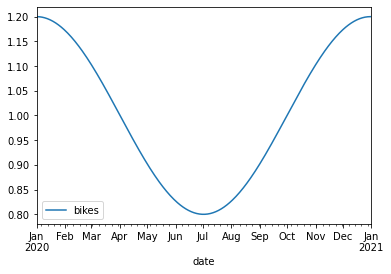

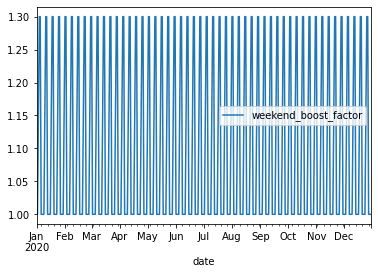

In [2]:
# The python package "timeseries_generator" implements day-increment granularity.
# The columns will have to be manually
start_date = Timestamp("01-01-2020")
end_date = Timestamp("01-01-2021")

features_dict = {
        "station": ["station_1", "station_2"],
        "product": ["bikes"]
}


linear_trend = LinearTrend(coef=1.0, offset=1., col_name="my_linear_trend")
white_noise = WhiteNoise(stdev_factor=0.05)

seasonality = SinusoidalFactor(
    feature="product",
    col_name="product_seasonal_trend_factor",
    feature_values={
        "bikes": {
            "wavelength": 365.,
            "amplitude": 0.2,
            "phase": 365/4,
            "mean": 1.
        }
    }
)


weekday_factor = WeekdayFactor(
    col_name="weekend_boost_factor",
    factor_values={4: 1.15, 5: 1.3, 6: 1.3}  # Here we assign a factor of 1.15 to Friday, and 1.3 to Sat/Sun 
)


# Plotting the parameters
linear_trend.plot(start_date=start_date, end_date=end_date)
white_noise.plot(start_date=start_date, end_date=end_date)
seasonality.plot(start_date=start_date, end_date=end_date)
weekday_factor.plot(start_date=start_date, end_date=end_date)  # Using a smaller timerange here to keep the plot viewable



# Creating generator

In [3]:
g: Generator = Generator(
    factors={
        linear_trend,
        seasonality,
        white_noise,
        #weekday_factor,
    },
    features=features_dict,
    date_range=pd.date_range(start=start_date, end=end_date),
    base_value=10
)
    
df = g.generate()

<AxesSubplot:xlabel='date'>

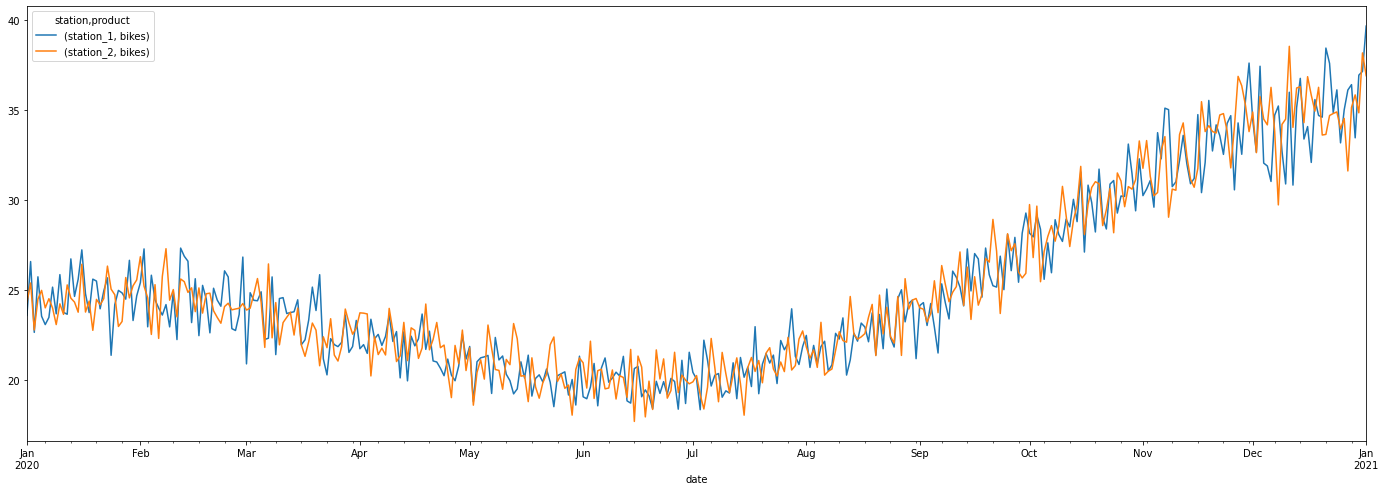

In [4]:

plot_df = df.set_index('date')
plot_df[['station', 'product', 'value']].pivot(columns=['station', 'product'], values='value').plot(figsize=(24,8))

In [5]:
df.head()


,date,station,product,base_amount,white_noise,product_seasonal_trend_factor,my_linear_trend,total_factor,value
0,2020-01-01,station_1,bikes,10,0.982843,1.200000,2.000000,2.358824,23.588241
1,2020-01-01,station_2,bikes,10,1.012792,1.200000,2.000000,2.430701,24.307014
2,2020-01-02,station_1,bikes,10,1.105955,1.199970,2.002725,2.657842,26.578423
3,2020-01-02,station_2,bikes,10,1.056424,1.199970,2.002725,2.538808,25.388083
4,2020-01-03,station_1,bikes,10,0.940974,1.199881,2.005450,2.264268,22.642685
